## Week 7: [K Nearest Neighbors (KNN)](https://scikit-learn.org/stable/modules/neighbors.html) Exercise


#### ``Data``

[Paper](https://tibshirani.su.domains/ftp/lars.pdf): Efron et al. (2004): “Least Angle Regression,” Annals of Statistics (with discussion), 407–499.

[Data description](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html): 10 baseline variables (age, sex, body mass index, average blood pressure, and six blood serum measurements) and the response of interest (a quantitative measure of disease progression one year after baseline readings) for n = 442 diabetes patients.

### Import libraries

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import os

# ML/stats
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import Image
%matplotlib inline

---
### Task A: Read data

---

In [ ]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [ ]:
df = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    delimiter='\t'
)

df.head(2)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


In [ ]:
df2 = pd.read_csv(
    'https://raw.githubusercontent.com/jiristo/MLdiabetes_inpectplot/master/diabetes_data.csv'
)

df2.head(2)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


---
### Task B: Data preprocessing

---

``rename columns``

In [ ]:
df.columns = [
    'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu', 'disease_progression']

df.head(2)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


``split data into training and test``

In [ ]:
# define outcome #
##################
y = df['disease_progression'].values

# define features #
###################
X = df[['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int)
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['disease_progression', 'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']

---
### Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

Note: I am going to perform EDA with the non-standardized feature values but when we fit the model, I will work with the standardized features. Why?

`` check if any missing values``

In [ ]:
df_train.isna().sum()

disease_progression    0
age                    0
sex                    0
bmi                    0
map                    0
tc                     0
ldl                    0
hdl                    0
tch                    0
ltg                    0
glu                    0
dtype: int64

``check distributions``

using describe()

In [ ]:
df_train.describe()

,disease_progression,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
count,309.000000,309.000000,309.000000,309.00000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,151.436893,48.847896,1.456311,26.38479,94.623430,189.718447,116.053398,49.331715,4.137605,4.661264,91.326861
std,75.288278,13.207123,0.498896,4.38726,14.125574,34.158839,30.236901,12.758655,1.309134,0.521852,11.637934
min,31.000000,19.000000,1.000000,18.00000,62.000000,110.000000,41.600000,25.000000,2.000000,3.258100,58.000000
25%,85.000000,39.000000,1.000000,23.30000,84.000000,164.000000,96.200000,40.000000,3.000000,4.290500,84.000000
50%,140.000000,51.000000,1.000000,25.80000,93.000000,187.000000,114.600000,47.000000,4.000000,4.634700,92.000000
75%,214.000000,59.000000,2.000000,29.20000,105.000000,212.000000,135.800000,56.000000,5.000000,5.023900,98.000000
max,336.000000,79.000000,2.000000,42.20000,133.000000,300.000000,242.400000,98.000000,9.090000,6.107000,124.000000


using hist()

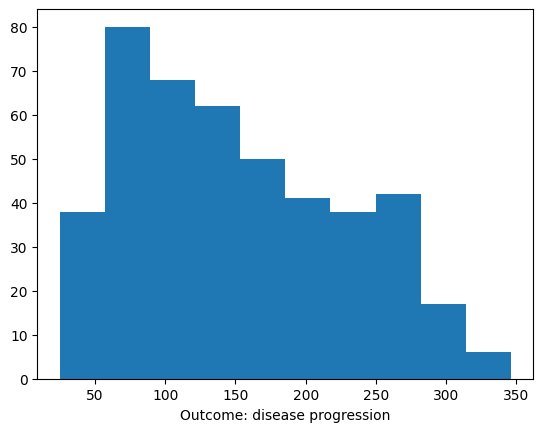

In [ ]:
df.disease_progression.hist(grid=False)
plt.xlabel('Outcome: disease progression');

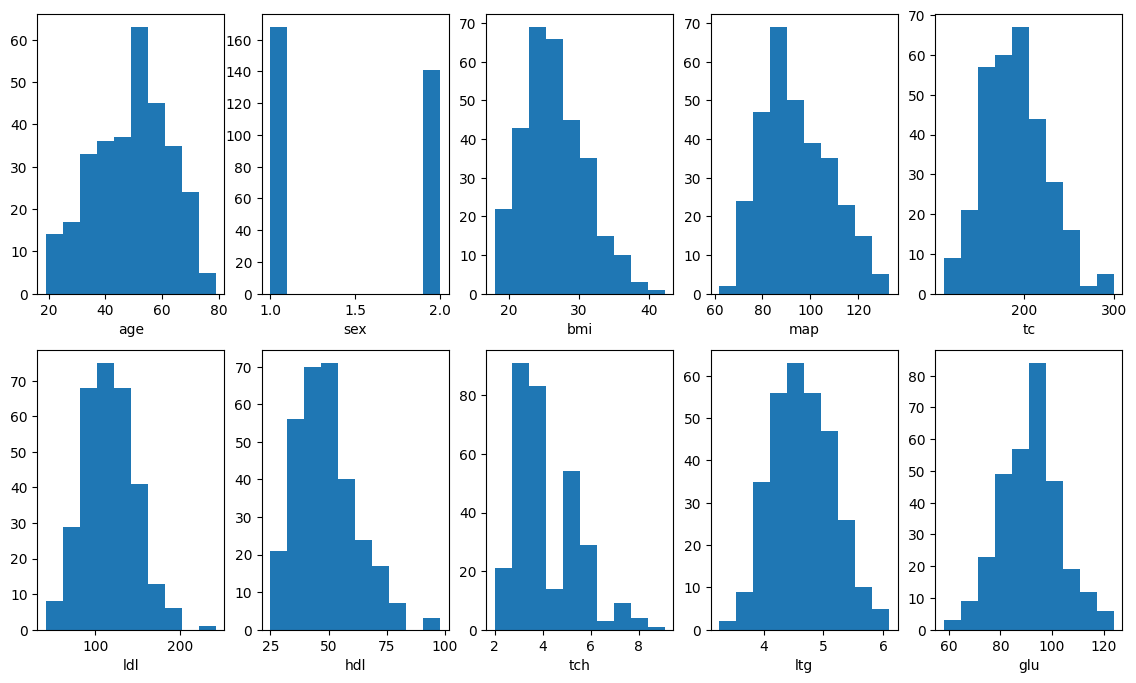

In [ ]:
columns = ['age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14,8))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

``correlation matrix of outcome and feature variables``

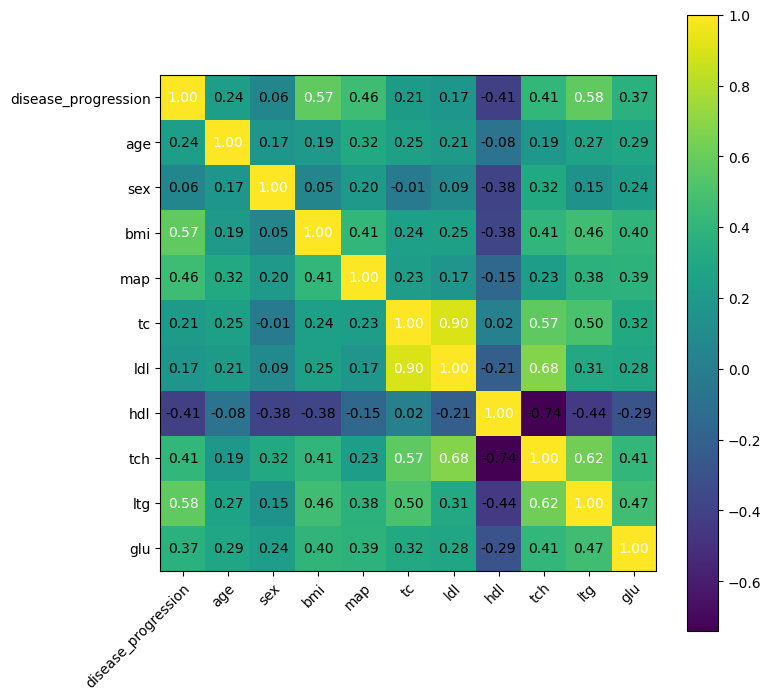

In [ ]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(8, 8)
)

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict diabetes progression?

``histogram of features and outcome``

Let's focus on the outcome variable (disease_progression) and BMI for the moment.

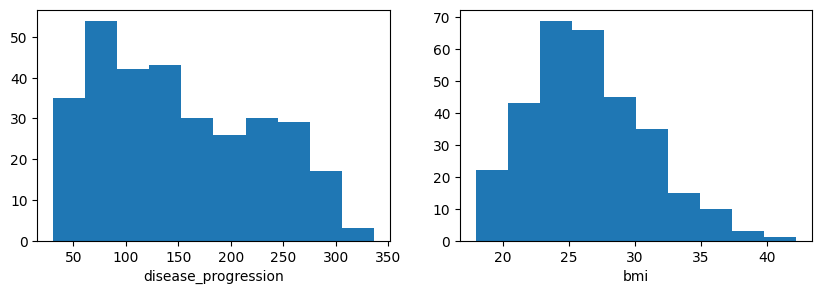

In [ ]:
columns = ['disease_progression', 'bmi']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

---
### Task C: Run KNN to predict disease progression. Comment on RMSE.
---

---
### Task D: Experiment with the distance metric and number of neighbors. Comment on RMSE.
---